In [1]:
# LO CIRCUITS
# can always get a unitary matrix from a LO circuit in Perceval
# we can convert a matrix into a ZW circuit in optyx
# the opposite way is how we evaluate LO circuits in perce|val

In [2]:
# MORE GENERAL CIRCUITS
#

In [3]:
import numpy as np

import perceval as pcvl
from perceval import catalog

In [65]:
import numpy as np

import perceval as pcvl
from perceval import catalog
p = pcvl.Processor("SLOS", 6)
p.add(0, catalog["postprocessed cnot"].build_processor())
p.add(0, pcvl.BS.H())
p.add(2, pcvl.Detector.pnr())
p.add(3, pcvl.Detector.pnr())
p.add(0, pcvl.Detector.pnr())
p.add(1, pcvl.Detector.pnr())
# 2 measured modes
# offset = 0 means that there is 0 empty modes between the measured modes and the circuit
# the default circuit is an empty circuit
ff_X = pcvl.FFCircuitProvider(2, 0, pcvl.Circuit(2))

# Now if we measure a logical state |1>, we need to perform a permutation of the modes
ff_X.add_configuration([0, 1], pcvl.PERM([1, 0]))

p.add(2, ff_X)
phi = pcvl.P("phi")
# Like Circuits and Processors, we can chain the `add` methods
ff_Z = pcvl.FFConfigurator(2, 3, pcvl.PS(phi), {"phi": 0}).add_configuration([0, 1], {"phi": np.pi})
p.add(0, ff_Z)

In [66]:
import numpy as np

import perceval as pcvl
from perceval import catalog


# Creation of the qubit to transmit
alpha = np.random.random()
beta = np.random.random() * np.exp(2 * np.pi * 1j * np.random.random())
# alpha |0> + beta |1> in dual rail encoding
to_transmit = (0.7071067811865476+0j)*pcvl.BasicState([1, 0]) + (-0.21850801222441052+0.6724985119639574j)*pcvl.BasicState([0, 1]) 
to_transmit.normalize()

alpha = to_transmit[pcvl.BasicState([1, 0])]  # Normalized
beta = to_transmit[pcvl.BasicState([0, 1])]

sg = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
bell_state = sg.bell_state("phi+")

input_state = to_transmit * bell_state
#input_state = bell_state
p.min_detected_photons_filter(2)

# Since we use a "custom" (understand not a BasicState) input state,
# we have to add the heralds from the post-processed cnot manually
input_state *= pcvl.BasicState([0, 0])

p.with_input(input_state)

res = p.probs()
print(res)

{'results': BSDistribution(<class 'float'>, {|1,0,1,0,1,0>: 0.12500000000000003, |0,1,1,0,1,0>: 0.12499999999999996, |0,1,1,0,0,1>: 0.12500000000000003, |1,0,0,1,1,0>: 0.125, |1,0,0,1,0,1>: 0.125, |1,0,1,0,0,1>: 0.12500000000000003, |0,1,0,1,1,0>: 0.12499999999999996, |0,1,0,1,0,1>: 0.12500000000000003}), 'global_perf': 0.11111111111111112}


In [67]:
bell_state

0.707*|0,1,0,1>+0.707*|1,0,1,0>

In [68]:
to_transmit

(-0.219+0.672I)*|0,1>+0.707*|1,0>

In [69]:
input_state

(-0.155+0.476I)*|0,1,0,1,0,1,0,0>+(-0.155+0.476I)*|0,1,1,0,1,0,0,0>+0.5*|1,0,0,1,0,1,0,0>+0.5*|1,0,1,0,1,0,0,0>

In [70]:
from optyx._utils import matrix_to_zw
from optyx import Channel, mode, qmode, photonic, bit
from optyx.classical import ClassicalFunction, BitControlledGate
from perceval.components.detector import DetectionType
from optyx.core.channel import Spider, Diagram, Measure
from optyx.classical import Select
from optyx.photonic import Create
from optyx.postselect_parser import compile_postselect
from optyx.core.zw import Endo

n_modes = p.circuit_size
circuit = photonic.Id(n_modes)
heralds = p.heralds

layer = photonic.Id(0)
for m in range(n_modes):
    if m in heralds:
        layer @= Create(heralds[m])
    else:
        layer @= photonic.Id(1)
circuit = layer >> circuit

def invert_perm(p):
    q = [0] * len(p)
    for out, inn in enumerate(p):
        q[inn] = out
    return q

for c in p.components:
    component = c[1]
    wires = c[0]
    left = circuit.cod[:min(wires)]
    right = circuit.cod[max(wires)+1:]
    if isinstance(component, pcvl.Detector):
        if component.type == DetectionType.PNR:
            circuit_component = photonic.NumberResolvingMeasurement(len(wires))
        elif component.type == DetectionType.Threshold:
            circuit_component = photonic.PhotonThresholdMeasurement(len(wires))
        else:
            raise ValueError(f"Unsupported perceval detector type: {c.type}")
        box = circuit_component
    elif isinstance(component, pcvl.components.feed_forward_configurator.FFCircuitProvider):
        default_action = matrix_to_zw(
            np.array(
                component.default_circuit.U,
                dtype=np.complex128
            )
        )

        n_classical_wires = len(list(component._map.keys())[0])
        n_action_wires = len(default_action.dom)
        n_offset = np.abs(component._offset)

        if component._offset < 0:
            p_input = (
                list(range(n_action_wires + n_offset, n_action_wires + n_offset + n_classical_wires)) +
                list(range(0, n_action_wires)) +
                list(range(n_action_wires, n_action_wires + n_offset))
            )
            input_permutation = Diagram.permutation(
                p_input,
                qmode**(n_action_wires + n_offset) @ mode**n_classical_wires
            )
            output_permutation = Diagram.permutation(
                invert_perm(p_input),
                input_permutation.cod
            )
            left = circuit.cod[:min(wires) - n_offset - n_action_wires]
            right = circuit.cod[max(wires) + 1:]

        else:
            p_input = (
                list(range(n_classical_wires, n_classical_wires + n_offset)) +
                list(range(0, n_classical_wires)) +
                list(range(n_classical_wires + n_offset, n_classical_wires + n_offset + n_action_wires))
            )
            input_permutation = Diagram.permutation(
                p_input,
                mode**n_classical_wires @ qmode**(n_action_wires + n_offset)
            )
            output_permutation = Diagram.permutation(
                invert_perm(p_input),
                input_permutation.cod
            )
            left = circuit.cod[:min(wires)]
            right = circuit.cod[max(wires) + n_offset + n_action_wires + 1:]

        for i, (state, action_circuit) in enumerate(component._map.items()):
            if i==0:
                box = mode**len(state) @ photonic.Id(len(default_action.dom))
            # if not i == len(component._map) - 1:
            copy = Spider(1, 2, mode)**len(state)
            permutation = Diagram.permutation(
                list(range(0, len(state)*2, 2)) + list(range(1, len(state)*2, 2)),
                mode**(2*len(state))
            )
            copied_wires = Diagram.id(mode**len(state))
            # else:
            #     copy = Diagram.id(mode**len(state))
            #     permutation = Diagram.id(mode**len(state))
            #     copied_wires = Diagram.id(mode**0)
            def f(x):
                if all(s == a for s, a in zip(list(state), x)):
                    return [1]
                else:
                    return [0]
            func = ClassicalFunction(f, mode**len(state), bit)
            action = matrix_to_zw(
                np.array(
                    action_circuit.U,
                    dtype=np.complex128
                )
            )
            ctrl_box = BitControlledGate(
                action,
                default_action
            )

            q_wires = qmode**len(default_action.dom)

            box >>= (
                copy @ q_wires >>
                permutation @ q_wires >>
                copied_wires @ func @ q_wires >>
                copied_wires @ ctrl_box

            )
        offset_wires = circuit.cod[len(left) + n_action_wires : len(left) + n_action_wires + n_offset] if component._offset < 0 else circuit.cod[len(left)+n_classical_wires:len(left)+n_classical_wires+n_offset]
        box = (
            input_permutation >>
            offset_wires @ box >>
            input_permutation.dagger()
        )

    elif isinstance(component, pcvl.components.feed_forward_configurator.FFConfigurator):
        default_action = matrix_to_zw(
            np.array(
                component.default_circuit.U,
                dtype=np.complex128
            )
        )

        n_classical_wires = len(list(component._configs.keys())[0])
        n_action_wires = len(default_action.dom)
        n_offset = np.abs(component._offset)

        if component._offset < 0:
            p_input = (
                list(range(n_action_wires + n_offset, n_action_wires + n_offset + n_classical_wires)) +
                list(range(0, n_action_wires)) +
                list(range(n_action_wires, n_action_wires + n_offset))
            )
            input_permutation = Diagram.permutation(
                p_input,
                #qmode**(n_action_wires + n_offset) @ mode**n_classical_wires,
                circuit.cod[min(wires) - n_offset - n_action_wires:max(wires) + 1]
            )
            output_permutation = Diagram.permutation(
                invert_perm(p_input),
                input_permutation.cod
            )

            left = circuit.cod[:min(wires) - n_offset - n_action_wires]
            right = circuit.cod[max(wires) + 1:]

        else:
            p_input = (
                list(range(n_classical_wires, n_classical_wires + n_offset)) +
                list(range(0, n_classical_wires)) +
                list(range(n_classical_wires + n_offset, n_classical_wires + n_offset + n_action_wires))
            )
            input_permutation = Diagram.permutation(
                p_input,
                #mode**n_classical_wires @ qmode**(n_action_wires + n_offset),
                circuit.cod[min(wires):max(wires) + n_offset + n_action_wires + 1]
            )
            output_permutation = Diagram.permutation(
                invert_perm(p_input),
                input_permutation.cod
            )
            left = circuit.cod[:min(wires)]
            right = circuit.cod[max(wires) + n_offset + n_action_wires + 1:]

        for i, (state, symbol_values) in enumerate(component._configs.items()):
            if i==0:
                box = mode**len(state) @ photonic.Id(len(default_action.dom))
            # if not i == len(component._configs) - 1:
            copy = Spider(1, 2, mode)**len(state)
            permutation = Diagram.permutation(
                list(range(0, len(state)*2, 2)) + list(range(1, len(state)*2, 2)),
                mode**(2*len(state))
            )
            copied_wires = Diagram.id(mode**len(state))
            # else:
            #     copy = Diagram.id(mode**len(state))
            #     permutation = Diagram.id(mode**len(state))
            #     copied_wires = Diagram.id(mode**0)
            def f(x):
                if all(s == a for s, a in zip(list(state), x)):
                    return [1]
                else:
                    return [0]
            func = ClassicalFunction(f, mode**len(state), bit)
            free_symbols = component._controlled.U.free_symbols
            action_U = np.array(component._controlled.U.subs(
                {symbol: symbol_value for symbol, symbol_value in zip(free_symbols, symbol_values.values())}
            ).evalf(), dtype=np.complex128)
            action = matrix_to_zw(
                np.array(
                    action_U,
                    dtype=np.complex128
                )
            )
            ctrl_box = BitControlledGate(
                action,
                default_action
            )

            q_wires = qmode**len(default_action.dom)

            box >>= (
                copy @ q_wires >>
                permutation @ q_wires >>
                copied_wires @ func @ q_wires >>
                copied_wires @ ctrl_box

            )
        offset_wires = circuit.cod[len(left) + n_action_wires : len(left) + n_action_wires + n_offset] if component._offset < 0 else circuit.cod[len(left)+n_classical_wires:len(left)+n_classical_wires+n_offset]
        box = (
            input_permutation >>
            offset_wires @ box >>
            output_permutation
        )
    elif isinstance(component, pcvl.components.Barrier):
        continue
    elif hasattr(component, 'U'):
        circuit_component = matrix_to_zw(np.array(component.U, dtype=np.complex128))
        box = Channel(
            name=c[1].name,
            kraus=circuit_component
        )
    else:
        raise ValueError(f"Unsupported perceval component type: {type(component)}")
    circuit_layer = left @ box @ right
    circuit >>= circuit_layer

layer = photonic.Id(0)
for m in range(n_modes):
    if m in heralds:
        layer @= Select(heralds[m])
    else:
        layer @= circuit.cod[m]
circuit >>= layer

#post-selection
circuit >>= Measure(circuit.cod)
n_postselected_wires = len(circuit.cod)
copy = Spider(1, 2, mode)**n_postselected_wires
permutation = Diagram.permutation(
    list(range(0, n_postselected_wires*2, 2)) + list(range(1, n_postselected_wires*2, 2)),
    mode**(2*n_postselected_wires)
)
circuit >>= copy >> permutation
postselect_f = ClassicalFunction(
    compile_postselect(str(p.post_select_fn)),
    mode**n_postselected_wires,
    bit
)
circuit >>= postselect_f @ mode**n_postselected_wires
postselection = BitControlledGate(
    Diagram.id(mode**n_postselected_wires),
    Channel(
        "PostSelection",
        Endo(0)**n_postselected_wires,
        mode**n_postselected_wires,
        mode**n_postselected_wires
    ),
    classical=True
)
circuit >>= postselection

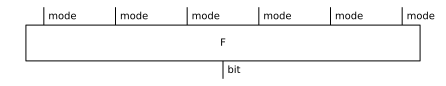

In [71]:
postselect_f.draw()

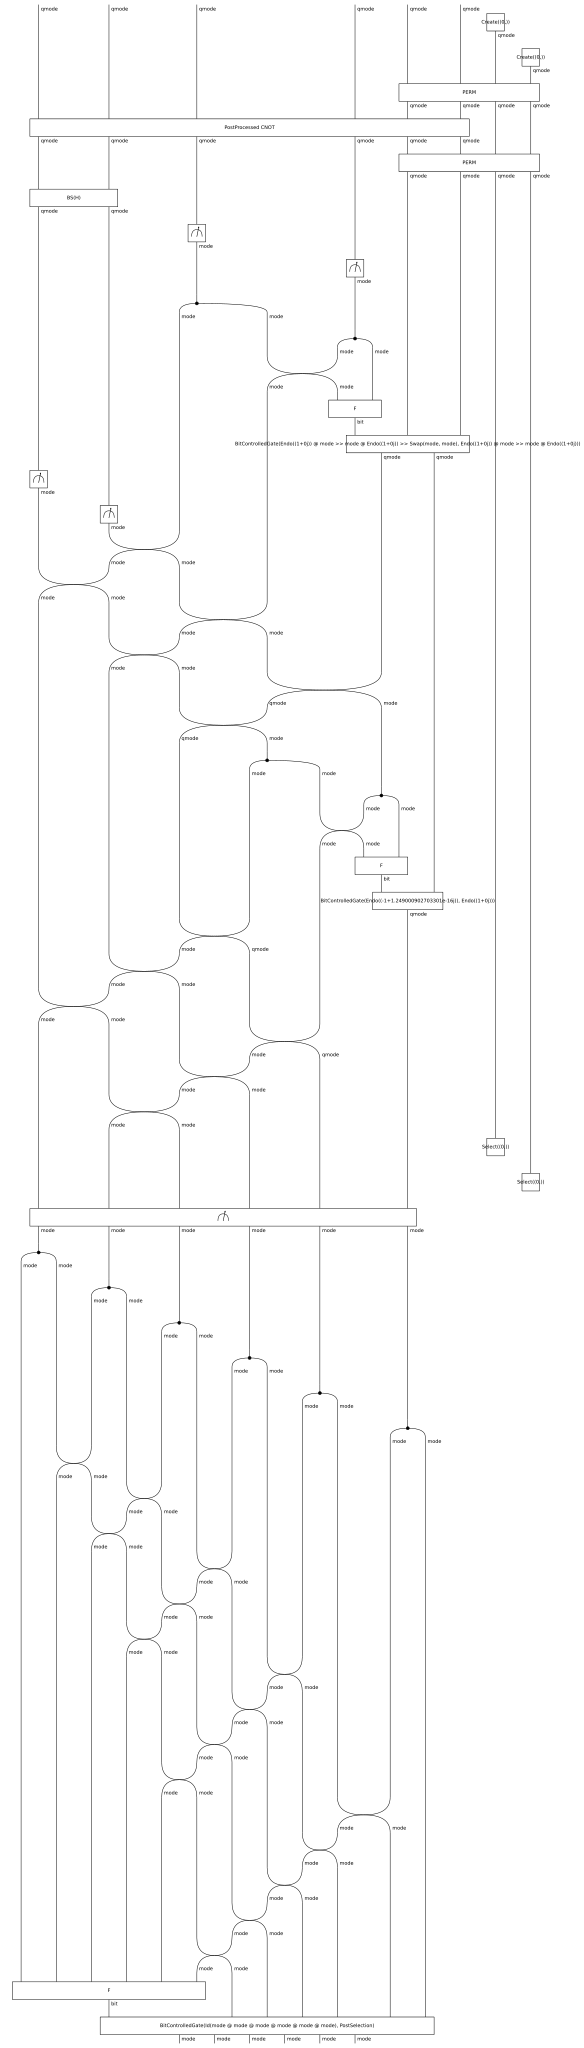

In [72]:
circuit.draw()

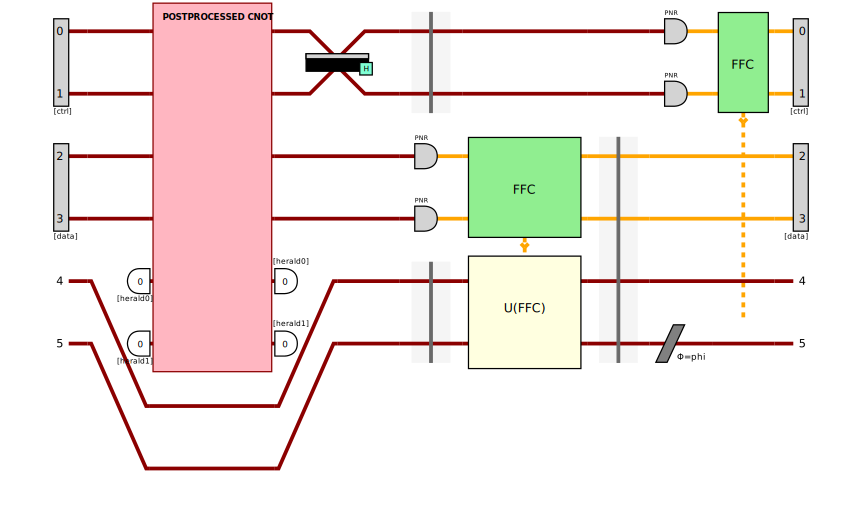

In [73]:
pcvl.pdisplay(p)


In [74]:
from optyx.qubits import Z, Scalar, Ket
from optyx.photonic import DualRail

bell_state = Z(0, 2) @ Scalar(0.5**0.5)

In [75]:
transmit = Ket("+") >> Z(1, 1, 0.3)

In [76]:
transmit.eval().amplitudes()

{(0,): (0.7071067811865476+0j),
 (1,): (-0.21850801222441052+0.6724985119639574j)}

In [77]:
inp = transmit @ bell_state

In [78]:
dist = (
    transmit @ bell_state >>
    DualRail(3) >>
    circuit
).eval().prob_dist()

In [79]:
res

{'results': BSDistribution(float,
                {|1,0,1,0,1,0>: 0.12500000000000003,
                 |0,1,1,0,1,0>: 0.12499999999999996,
                 |0,1,1,0,0,1>: 0.12500000000000003,
                 |1,0,0,1,1,0>: 0.125,
                 |1,0,0,1,0,1>: 0.125,
                 |1,0,1,0,0,1>: 0.12500000000000003,
                 |0,1,0,1,1,0>: 0.12499999999999996,
                 |0,1,0,1,0,1>: 0.12500000000000003}),
 'global_perf': 0.11111111111111112}

In [80]:
def check_dict_agreement(d1, d2, rtol=1e-5, atol=1e-8):
    # Check keys in d1 but not in d2
    for key in d1.keys() - d2.keys():
        print(f"Key {key} is in d1 but not in d2.")
    # Check keys in d2 but not in d1
    for key in d2.keys() - d1.keys():
        print(f"Key {key} is in d2 but not in d1.")
    # Check matching keys for value closeness
    for key in d1.keys() & d2.keys():
        if not np.isclose(d1[key], d2[key], rtol=rtol, atol=atol):
            print(f"Values for key {key} differ: {d1[key]} vs {d2[key]}")
            
check_dict_agreement(
    {tuple(k): v for k, v in dict(res["results"]).items()},
    dist
)


In [203]:
(
    inp >>
    DualRail(3)
).eval().amplitudes()

{(0, 1, 0, 1, 0, 1): (-0.15450849718747367+0.4755282581475768j),
 (0, 1, 1, 0, 1, 0): (-0.15450849718747367+0.4755282581475768j),
 (1, 0, 0, 1, 0, 1): (0.5+0j),
 (1, 0, 1, 0, 1, 0): (0.5+0j)}

In [108]:
input_state

(-0.155+0.476I)*|0,1,0,1,0,1,0,0>+(-0.155+0.476I)*|0,1,1,0,1,0,0,0>+0.5*|1,0,0,1,0,1,0,0>+0.5*|1,0,1,0,1,0,0,0>

In [110]:
catalog["postprocessed cnot"].build_processor()

In [204]:
p.components#[1][1]

[[[4, 5, 6, 7],
 [[0, 1, 2, 3, 4, 5],
 [[4, 5, 6, 7],

In [121]:
p.components[1][1].U

Matrix([
[0.577350269189626,                  0,                 0,                  0,  0.816496580927726,                  0],
[                0, -0.577350269189626, 0.577350269189626,  0.577350269189626,                  0,                  0],
[                0,  0.577350269189626, 0.577350269189626,                  0,                  0,  0.577350269189626],
[                0,  0.577350269189626,                 0,  0.577350269189626,                  0, -0.577350269189626],
[0.816496580927726,                  0,                 0,                  0, -0.577350269189626,                  0],
[                0,                  0, 0.577350269189626, -0.577350269189626,                  0, -0.577350269189626]])

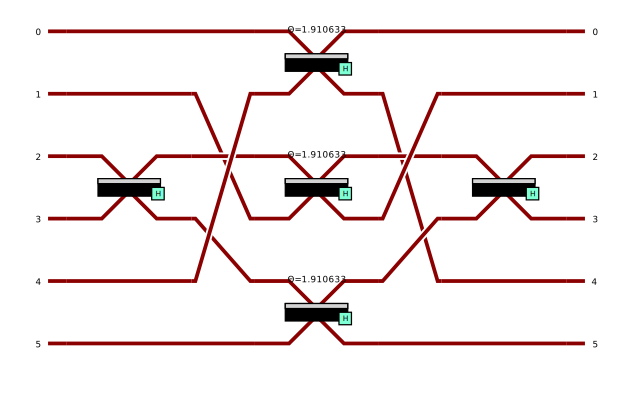

In [122]:
pcvl.pdisplay(p.components[1][1])


In [123]:
p.flatten()

[([4, 5, 6, 7],
  <perceval.components.unitary_components.PERM at 0x736c865d43e0>),
 ([2, 3], <perceval.components.unitary_components.BS at 0x736c8650c3b0>),
 ([1, 2, 3, 4],
  <perceval.components.unitary_components.PERM at 0x736c8650e840>),
 ([0, 1, 2, 3, 4, 5],
  <perceval.components.unitary_components.Barrier at 0x736c8650f5c0>),
 ([0, 1], <perceval.components.unitary_components.BS at 0x736c8650fef0>),
 ([2, 3], <perceval.components.unitary_components.BS at 0x736c865d6330>),
 ([4, 5], <perceval.components.unitary_components.BS at 0x736c865d42c0>),
 ([1, 2, 3, 4],
  <perceval.components.unitary_components.PERM at 0x736c865d4620>),
 ([2, 3], <perceval.components.unitary_components.BS at 0x736c865d4e90>),
 ([4, 5, 6, 7],
  <perceval.components.unitary_components.PERM at 0x736c865d7740>)]

In [ ]:
a = pcvl.Processor("SLOS", 6)
a.add(0,p.components[1][1])
# Creation of the qubit to transmit
alpha = np.random.random()
beta = np.random.random() * np.exp(2 * np.pi * 1j * np.random.random())
# alpha |0> + beta |1> in dual rail encoding
to_transmit = (0.7071067811865476+0j)*pcvl.BasicState([1, 0]) + (-0.21850801222441052+0.6724985119639574j)*pcvl.BasicState([0, 1]) 
to_transmit.normalize()

alpha = to_transmit[pcvl.BasicState([1, 0])]  # Normalized
beta = to_transmit[pcvl.BasicState([0, 1])]

sg = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
bell_state = sg.bell_state("phi+")

input_state = to_transmit * bell_state

a.min_detected_photons_filter(3)

# Since we use a "custom" (understand not a BasicState) input state,
# we have to add the heralds from the post-processed cnot manually
#input_state *= pcvl.BasicState([0, 0])

a.with_input(input_state)

res = a.probs()
res

{'results': BSDistribution(float,
                {|0,2,0,1,0,0>: 0.01851851851851852,
                 |0,0,1,1,0,1>: 0.00925925925925925,
                 |0,1,0,0,0,2>: 0.01851851851851852,
                 |0,0,0,1,0,2>: 0.01851851851851852,
                 |0,0,2,1,0,0>: 0.01851851851851852,
                 |0,0,1,0,1,1>: 0.01968488843613294,
                 |0,0,2,0,1,0>: 0.01851851851851852,
                 |2,0,1,0,0,0>: 0.037037037037037035,
                 |1,1,1,0,0,0>: 0.009259259259259255,
                 |1,0,1,0,1,0>: 0.00925925925925926,
                 |0,0,0,0,1,2>: 0.037037037037037035,
                 |2,1,0,0,0,0>: 0.037037037037037056,
                 |0,0,0,3,0,0>: 0.05555555555555554,
                 |1,0,0,1,0,1>: 0.018518518518518514,
                 |0,2,1,0,0,0>: 0.018518518518518514,
                 |2,0,0,0,0,1>: 0.037037037037037035,
                 |1,1,0,0,1,0>: 0.009259259259259259,
                 |1,0,0,0,1,1>: 0.00925925925925926,
    

In [149]:
from optyx._utils import matrix_to_zw
from optyx import Channel, mode, qmode, photonic, bit
from optyx.classical import ClassicalFunction, BitControlledGate
from perceval.components.detector import DetectionType
from optyx.core.channel import Spider, Diagram
from optyx.classical import Select
from optyx.photonic import Create

n_modes = p.circuit_size
circuit = photonic.Id(n_modes)
heralds = p.heralds

layer = photonic.Id(0)
for m in range(n_modes):
    if m in heralds:
        layer @= Create(heralds[m])
    else:
        layer @= photonic.Id(1)
circuit = layer >> circuit

def invert_perm(p):
    q = [0] * len(p)
    for out, inn in enumerate(p):
        q[inn] = out
    return q

for c in a.components:
    component = c[1]
    wires = c[0]
    left = circuit.cod[:min(wires)]
    right = circuit.cod[max(wires)+1:]
    if isinstance(component, pcvl.Detector):
        if component.type == DetectionType.PNR:
            circuit_component = photonic.NumberResolvingMeasurement(len(wires))
        elif component.type == DetectionType.Threshold:
            circuit_component = photonic.PhotonThresholdMeasurement(len(wires))
        else:
            raise ValueError(f"Unsupported perceval detector type: {c.type}")
        box = circuit_component
    elif isinstance(component, pcvl.components.feed_forward_configurator.FFCircuitProvider):
        default_action = matrix_to_zw(
            np.array(
                component.default_circuit.U,
                dtype=np.complex128
            )
        )

        n_classical_wires = len(list(component._map.keys())[0])
        n_action_wires = len(default_action.dom)
        n_offset = np.abs(component._offset)

        if component._offset < 0:
            p_input = (
                list(range(n_action_wires + n_offset, n_action_wires + n_offset + n_classical_wires)) +
                list(range(0, n_action_wires)) +
                list(range(n_action_wires, n_action_wires + n_offset))
            )
            input_permutation = Diagram.permutation(
                p_input,
                qmode**(n_action_wires + n_offset) @ mode**n_classical_wires
            )
            output_permutation = Diagram.permutation(
                invert_perm(p_input),
                input_permutation.cod
            )
            left = circuit.cod[:min(wires) - n_offset - n_action_wires]
            right = circuit.cod[max(wires) + 1:]

        else:
            p_input = (
                list(range(n_classical_wires, n_classical_wires + n_offset)) +
                list(range(0, n_classical_wires)) +
                list(range(n_classical_wires + n_offset, n_classical_wires + n_offset + n_action_wires))
            )
            input_permutation = Diagram.permutation(
                p_input,
                mode**n_classical_wires @ qmode**(n_action_wires + n_offset)
            )
            output_permutation = Diagram.permutation(
                invert_perm(p_input),
                input_permutation.cod
            )
            left = circuit.cod[:min(wires)]
            right = circuit.cod[max(wires) + n_offset + n_action_wires + 1:]

        for i, (state, action_circuit) in enumerate(component._map.items()):
            if i==0:
                box = mode**len(state) @ photonic.Id(len(default_action.dom))
            # if not i == len(component._map) - 1:
            copy = Spider(1, 2, mode)**len(state)
            permutation = Diagram.permutation(
                list(range(0, len(state)*2, 2)) + list(range(1, len(state)*2, 2)),
                mode**(2*len(state))
            )
            copied_wires = Diagram.id(mode**len(state))
            # else:
            #     copy = Diagram.id(mode**len(state))
            #     permutation = Diagram.id(mode**len(state))
            #     copied_wires = Diagram.id(mode**0)
            def f(x):
                if all(s == a for s, a in zip(list(state), x)):
                    return [1]
                else:
                    return [0]
            func = ClassicalFunction(f, mode**len(state), bit)
            action = matrix_to_zw(
                np.array(
                    action_circuit.U,
                    dtype=np.complex128
                )
            )
            ctrl_box = BitControlledGate(
                action,
                default_action
            )

            q_wires = qmode**len(default_action.dom)

            box >>= (
                copy @ q_wires >>
                permutation @ q_wires >>
                copied_wires @ func @ q_wires >>
                copied_wires @ ctrl_box

            )
        offset_wires = circuit.cod[len(left) + n_action_wires : len(left) + n_action_wires + n_offset] if component._offset < 0 else circuit.cod[len(left)+n_classical_wires:len(left)+n_classical_wires+n_offset]
        box = (
            input_permutation >>
            offset_wires @ box >>
            input_permutation.dagger()
        )

    elif isinstance(component, pcvl.components.feed_forward_configurator.FFConfigurator):
        default_action = matrix_to_zw(
            np.array(
                component.default_circuit.U,
                dtype=np.complex128
            )
        )

        n_classical_wires = len(list(component._configs.keys())[0])
        n_action_wires = len(default_action.dom)
        n_offset = np.abs(component._offset)

        if component._offset < 0:
            p_input = (
                list(range(n_action_wires + n_offset, n_action_wires + n_offset + n_classical_wires)) +
                list(range(0, n_action_wires)) +
                list(range(n_action_wires, n_action_wires + n_offset))
            )
            input_permutation = Diagram.permutation(
                p_input,
                #qmode**(n_action_wires + n_offset) @ mode**n_classical_wires,
                circuit.cod[min(wires) - n_offset - n_action_wires:max(wires) + 1]
            )
            output_permutation = Diagram.permutation(
                invert_perm(p_input),
                input_permutation.cod
            )

            left = circuit.cod[:min(wires) - n_offset - n_action_wires]
            right = circuit.cod[max(wires) + 1:]

        else:
            p_input = (
                list(range(n_classical_wires, n_classical_wires + n_offset)) +
                list(range(0, n_classical_wires)) +
                list(range(n_classical_wires + n_offset, n_classical_wires + n_offset + n_action_wires))
            )
            input_permutation = Diagram.permutation(
                p_input,
                #mode**n_classical_wires @ qmode**(n_action_wires + n_offset),
                circuit.cod[min(wires):max(wires) + n_offset + n_action_wires + 1]
            )
            output_permutation = Diagram.permutation(
                invert_perm(p_input),
                input_permutation.cod
            )
            left = circuit.cod[:min(wires)]
            right = circuit.cod[max(wires) + n_offset + n_action_wires + 1:]

        for i, (state, symbol_values) in enumerate(component._configs.items()):
            if i==0:
                box = mode**len(state) @ photonic.Id(len(default_action.dom))
            # if not i == len(component._configs) - 1:
            copy = Spider(1, 2, mode)**len(state)
            permutation = Diagram.permutation(
                list(range(0, len(state)*2, 2)) + list(range(1, len(state)*2, 2)),
                mode**(2*len(state))
            )
            copied_wires = Diagram.id(mode**len(state))
            # else:
            #     copy = Diagram.id(mode**len(state))
            #     permutation = Diagram.id(mode**len(state))
            #     copied_wires = Diagram.id(mode**0)
            def f(x):
                if all(s == a for s, a in zip(list(state), x)):
                    return [1]
                else:
                    return [0]
            func = ClassicalFunction(f, mode**len(state), bit)
            free_symbols = component._controlled.U.free_symbols
            action_U = np.array(component._controlled.U.subs(
                {symbol: symbol_value for symbol, symbol_value in zip(free_symbols, symbol_values.values())}
            ).evalf(), dtype=np.complex128)
            action = matrix_to_zw(
                np.array(
                    action_U,
                    dtype=np.complex128
                )
            )
            ctrl_box = BitControlledGate(
                action,
                default_action
            )

            q_wires = qmode**len(default_action.dom)

            box >>= (
                copy @ q_wires >>
                permutation @ q_wires >>
                copied_wires @ func @ q_wires >>
                copied_wires @ ctrl_box

            )
        offset_wires = circuit.cod[len(left) + n_action_wires : len(left) + n_action_wires + n_offset] if component._offset < 0 else circuit.cod[len(left)+n_classical_wires:len(left)+n_classical_wires+n_offset]
        box = (
            input_permutation >>
            offset_wires @ box >>
            output_permutation
        )
    elif isinstance(component, pcvl.components.Barrier):
        continue
    elif hasattr(component, 'U'):
        circuit_component = matrix_to_zw(np.array(component.U, dtype=np.complex128))
        box = Channel(
            name=c[1].name,
            kraus=circuit_component
        )
    else:
        raise ValueError(f"Unsupported perceval component type: {type(component)}")
    circuit_layer = left @ box @ right
    circuit >>= circuit_layer

layer = photonic.Id(0)
for m in range(n_modes):
    if m in heralds:
        layer @= Select(heralds[m])
    else:
        layer @= circuit.cod[m]
circuit >>= layer
    


In [151]:
dist = (
    inp >>
    DualRail(3) >>
    circuit
).eval().prob_dist()

In [175]:
dist[(0, 0, 0, 2, 0, 1)]

7.703719777548942e-34

In [171]:
{tuple(k): v for k, v in dict(res["results"]).items()}[(0, 0, 0, 0, 1, 2)]

0.037037037037037035

In [173]:
def check_dict_agreement(d1, d2, rtol=1e-5, atol=1e-8):
    # Check keys in d1 but not in d2
    for key in d1.keys() - d2.keys():
        print(f"Key {key} is in d1 but not in d2.")
    # Check keys in d2 but not in d1
    for key in d2.keys() - d1.keys():
        print(f"Key {key} is in d2 but not in d1.")
    # Check matching keys for value closeness
    for key in d1.keys() & d2.keys():
        if not np.isclose(d1[key], d2[key], rtol=rtol, atol=atol):
            print(f"Values for key {key} differ: {d1[key]} vs {d2[key]}")

In [174]:
check_dict_agreement(
    {tuple(k): v for k, v in dict(res["results"]).items()},
    dist
)


Key (0, 0, 0, 2, 0, 1) is in d2 but not in d1.
Key (0, 0, 1, 2, 0, 0) is in d2 but not in d1.


In [160]:
from perceval import BSDistribution

In [167]:
res

{'results': BSDistribution(float,
                {|0,2,0,1,0,0>: 0.01851851851851852,
                 |0,0,1,1,0,1>: 0.00925925925925925,
                 |0,1,0,0,0,2>: 0.01851851851851852,
                 |0,0,0,1,0,2>: 0.01851851851851852,
                 |0,0,2,1,0,0>: 0.01851851851851852,
                 |0,0,1,0,1,1>: 0.01968488843613294,
                 |0,0,2,0,1,0>: 0.01851851851851852,
                 |2,0,1,0,0,0>: 0.037037037037037035,
                 |1,1,1,0,0,0>: 0.009259259259259255,
                 |1,0,1,0,1,0>: 0.00925925925925926,
                 |0,0,0,0,1,2>: 0.037037037037037035,
                 |2,1,0,0,0,0>: 0.037037037037037056,
                 |0,0,0,3,0,0>: 0.05555555555555554,
                 |1,0,0,1,0,1>: 0.018518518518518514,
                 |0,2,1,0,0,0>: 0.018518518518518514,
                 |2,0,0,0,0,1>: 0.037037037037037035,
                 |1,1,0,0,1,0>: 0.009259259259259259,
                 |1,0,0,0,1,1>: 0.00925925925925926,
    